## Anomalies in wind unput data
### High wind generation with zero MPH data
There is a lot of data with zero wind speed (MPH) and non zero MWH, some generation value are quite high (> 1000).

My guess is that we have missing wind speed data that is reported as zero (instead of not assigned or empty) or there is incorrect or too coarse input data (wind speed or production are not accurate).

This item can be fixed with simple preprocessing step that removes from calculation such lines (zero wind speed, some wind energy output).

### Zero generation for relatively high MPH
For some BA there is some data with moderate and high wind speed that produce no MWH, even though the same wind speed and even lower wind speed at some hours do produce significant amount of energy.

There is no obvious fix to this issue. It can mean the error in data or data is real and and we should take more variables into consideration (exact hour value, holidays, etc) to find the explanation and functional dependancy.

### Missing (zero) generation for some BA (AZPS and PGE)
All the available input data for AZPS and PGE contains zero MWH (even for significant MPH).

Below there will be examples of all anomalies and some plots that show dependency of production (mwh) and other input (mainly mph). In the plots we can see the mentioned patterns as well as a lot of randomness (no obvious linear dependency from mph). Just skip the python code and go to the data and plots, may be ocasionally reading some comments in python code.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
windactuals = pd.read_csv("data/windactuals.txt")

In [3]:
import datetime

def decode_out_str_date(str):
    ''' 
    Converts string in usual date input format for model into date value.
    (format: %m/%d/%Y 0:00:00)
    '''
    return datetime.datetime.strptime(str, "%m/%d/%Y 0:00:00").date()

def convert_date_fields( dataFrame, srcFields, targetFields=None):
    ''' 
    Converts dataframe string columns containing dates in "%m/%d/%Y 0:00:00" 
    into columns with python date values.    
    ''' 
    doDrop = targetFields is None
    if (targetFields is None):
        targetFields = srcFields
    for src, target in zip(srcFields, targetFields):        
        tmpcol = '__tmpField_' + src
        dataFrame[tmpcol] = dataFrame[src].apply(decode_out_str_date)
        if (doDrop):
            dataFrame = dataFrame.drop(columns=[src])
        dataFrame = dataFrame.rename(columns = { tmpcol : target}) 
        return dataFrame

def add_dow_field(df, dateField):
    df['dow'] = df[dateField].apply(lambda dt : dt.isoweekday())
    return df

In [4]:
windactuals = convert_date_fields(windactuals, ["date"], ["dateObj"])
windactuals = add_dow_field(windactuals, "dateObj")

### data with zero mph and mwh > 500
more than 3500 data points.

In [5]:
windactuals[(windactuals.mph==0) & (windactuals.mwh > 500 )]

,BAcode,wxcode,date,Hour,mwh,mph,dateObj,dow
217,SCE,KELN,1/5/2018 0:00:00,17.0,791,0.0,2018-01-05,5
222,SCE,KELN,1/5/2018 0:00:00,18.0,1107,0.0,2018-01-05,5
223,SCE,KELN,1/5/2018 0:00:00,19.0,936,0.0,2018-01-05,5
228,SCE,KELN,1/5/2018 0:00:00,1.0,546,0.0,2018-01-05,5
264,SCE,KELN,1/6/2018 0:00:00,23.0,1109,0.0,2018-01-06,6
273,SCE,KELN,1/6/2018 0:00:00,12.0,1253,0.0,2018-01-06,6
278,SCE,KELN,1/6/2018 0:00:00,24.0,1032,0.0,2018-01-06,6
281,SCE,KELN,1/6/2018 0:00:00,5.0,528,0.0,2018-01-06,6
282,SCE,KELN,1/6/2018 0:00:00,7.0,1310,0.0,2018-01-06,6
287,SCE,KELN,1/6/2018 0:00:00,6.0,1018,0.0,2018-01-06,6


### Zero generation for relatively hight MPH
Here is data with zero MWH and MPH > 10
more than 6000 data points.

In [6]:
windactuals[(windactuals.mph > 10 ) & (windactuals.mwh == 0 )]


,BAcode,wxcode,date,Hour,mwh,mph,dateObj,dow
338,PGAE,KVCB,1/8/2018 0:00:00,14.0,0,10.29,2018-01-08,1
2238,PGAE,KVCB,2/17/2018 0:00:00,18.0,0,10.29,2018-02-17,6
4158,PGAE,KVCB,3/29/2018 0:00:00,15.0,0,10.29,2018-03-29,4
4911,PGAE,KVCB,4/14/2018 0:00:00,16.0,0,11.41,2018-04-14,6
8678,AZPS,KPHX,7/1/2018 0:00:00,18.0,0,10.29,2018-07-01,7
8680,AZPS,KPHX,7/1/2018 0:00:00,14.0,0,10.29,2018-07-01,7
8683,AZPS,KPHX,7/1/2018 0:00:00,19.0,0,10.29,2018-07-01,7
8750,CHPD,KEAT,7/1/2018 0:00:00,12.0,0,14.99,2018-07-01,7
8763,CHPD,KEAT,7/1/2018 0:00:00,14.0,0,17.22,2018-07-01,7
8769,CHPD,KEAT,7/1/2018 0:00:00,8.0,0,13.87,2018-07-01,7


In [7]:
plt.rcParams['figure.figsize'] = [12,7]

In [8]:
def slice_ba(df, bacode):
    return df[df.BAcode == bacode]

In [9]:
def plot_dependency(df, field, title = ''):
    p = sns.regplot(x=field, y='mwh', data=df, scatter_kws={'alpha':0.05}, line_kws={'color': 'red'})
    if (len(title)):
        p.set_title(title)
    plt.show()
#    sns.pairplot(df, x_vars=['mph', 'Hour'], y_vars=['mwh'])

### regression plots of MWH and MPH
you can see that the dependency of mwh and mph is not so linear, as we have some high generation values for relatively low wind speed. Even if we drop lines with zero MPH and non zero MWH the dependency will still be somewhat random.

In [10]:
availableBA = windactuals.BAcode.unique()

In [11]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

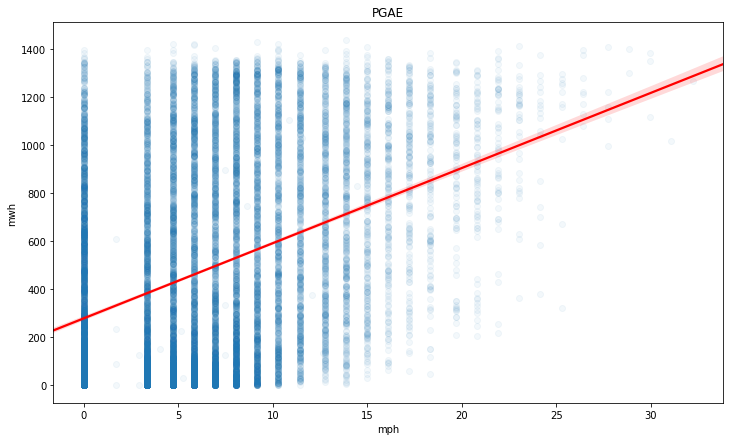

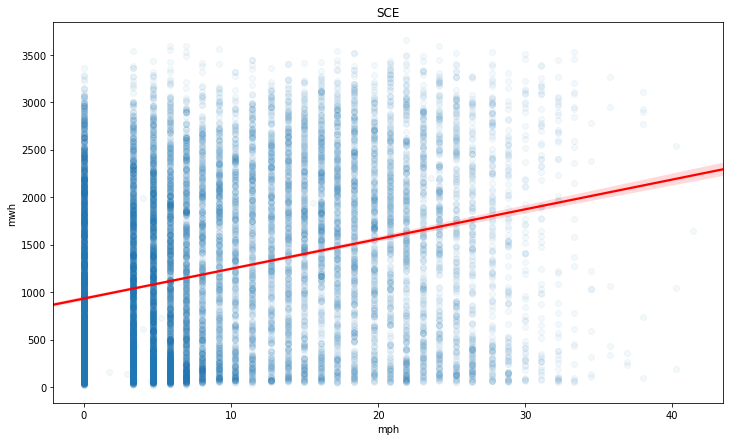

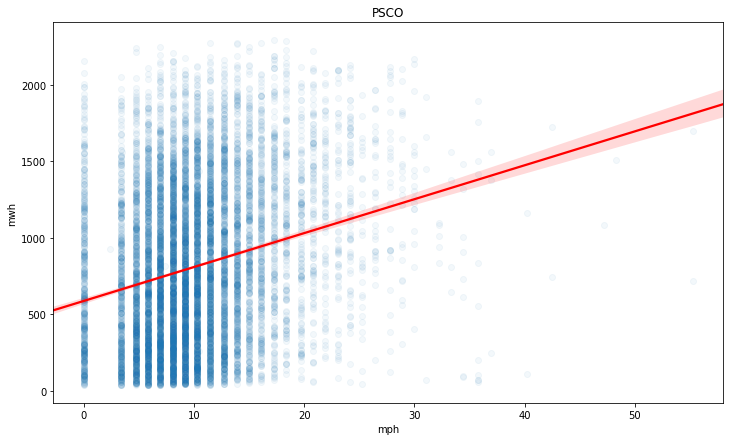

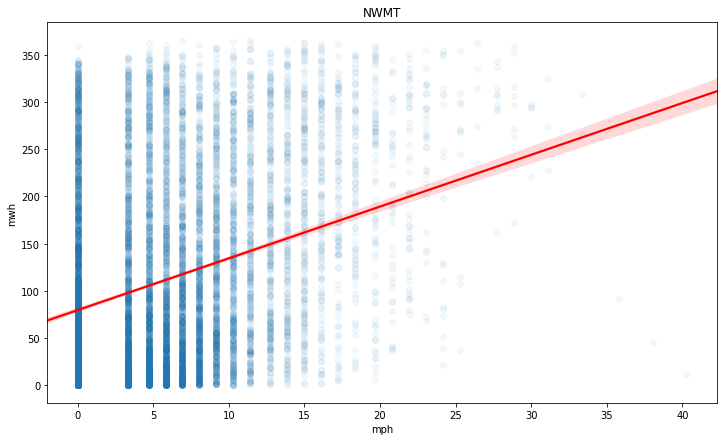

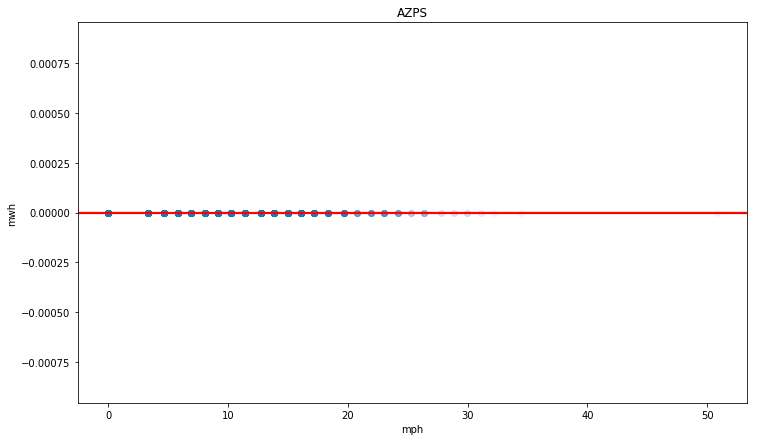

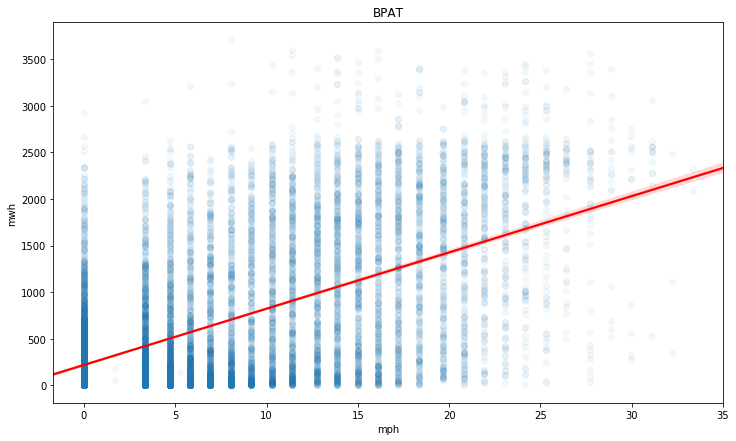

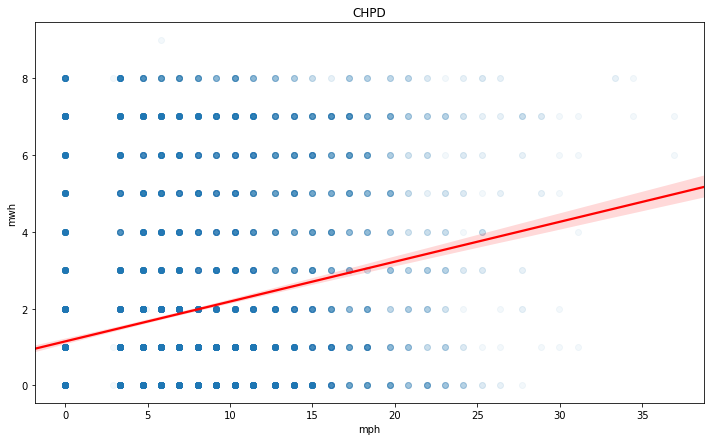

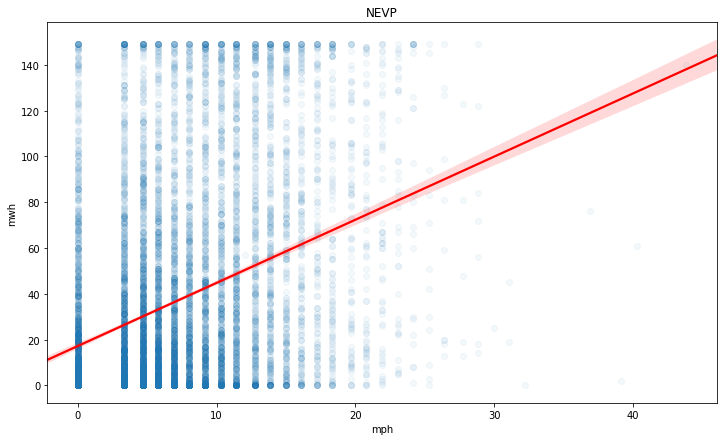

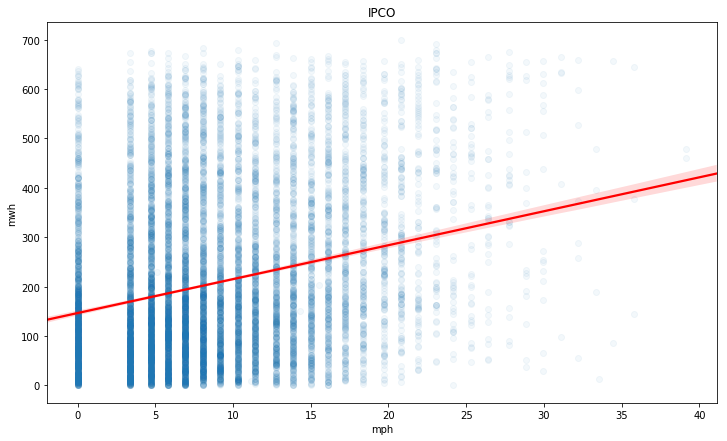

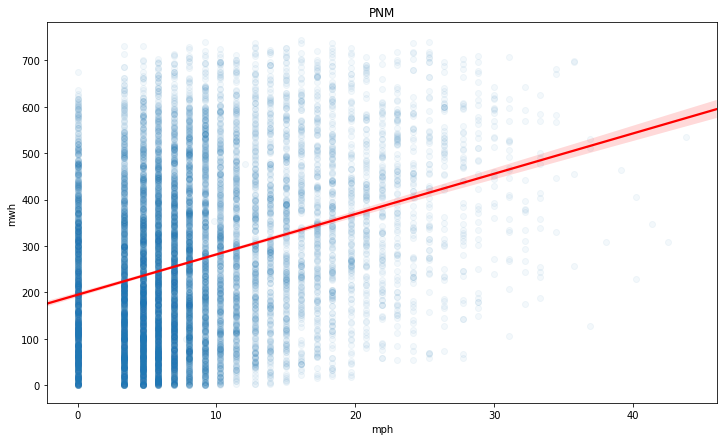

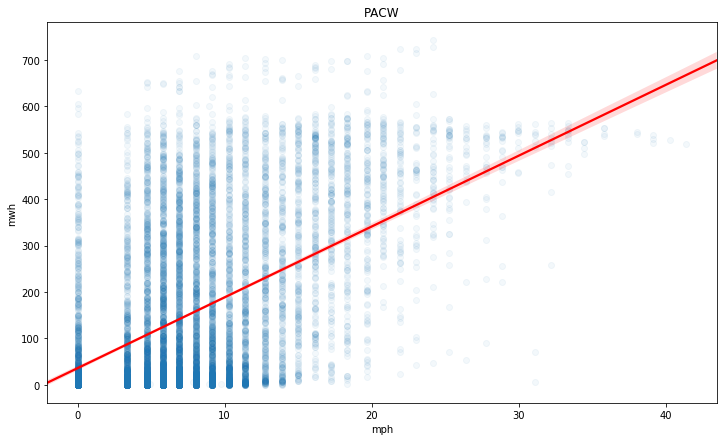

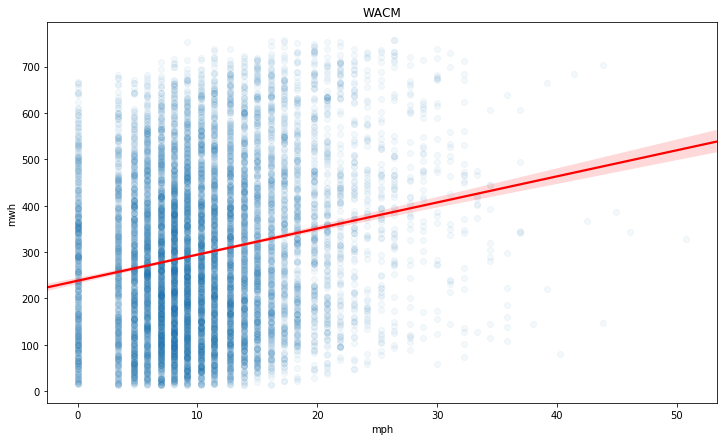

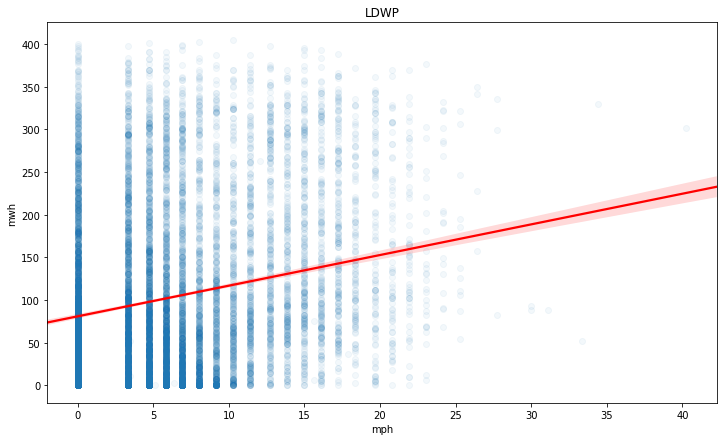

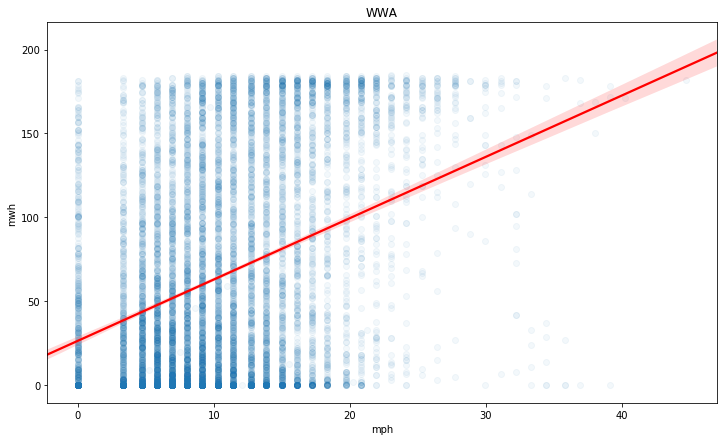

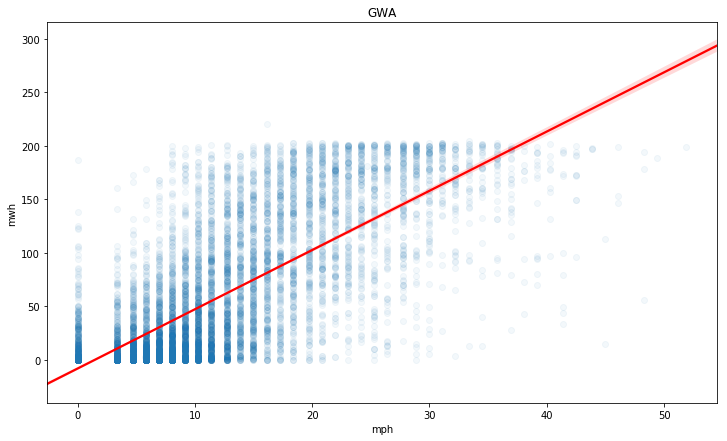

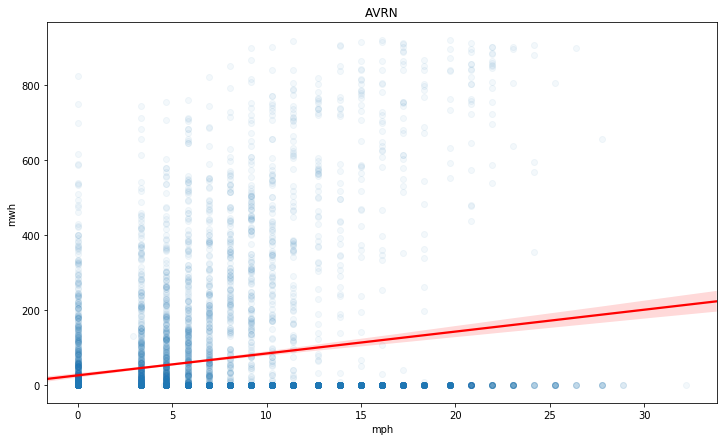

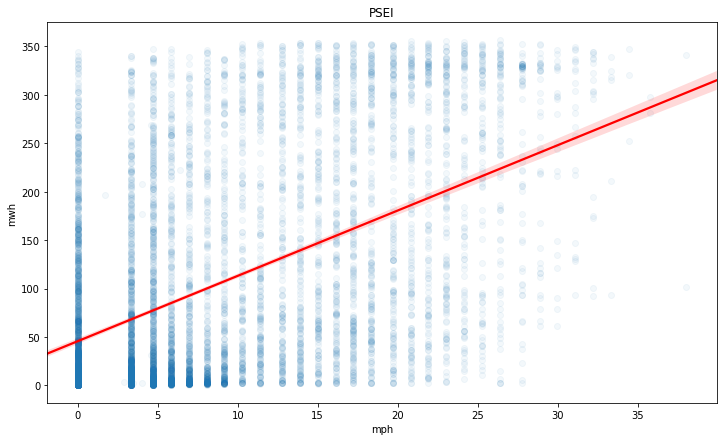

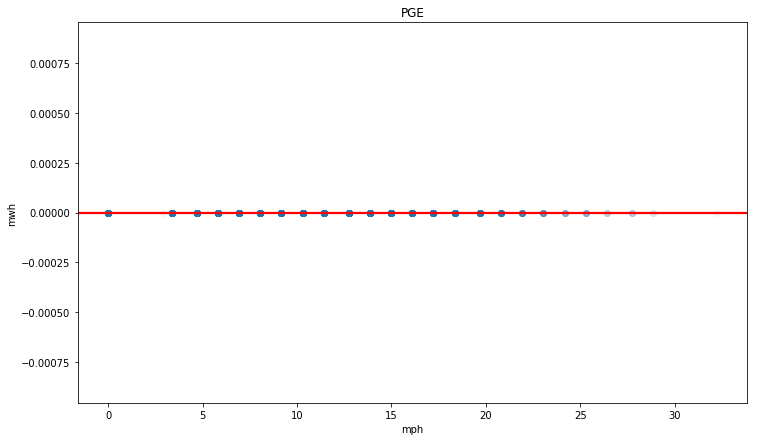

In [12]:
for ba in availableBA:
    dfBA = slice_ba(windactuals, ba)
    plot_dependency(dfBA, 'mph', ba)

In [13]:
def plot_production(df):
    plt.plot(df.dateObj, df.mwh)
    plt.title('wind generation')

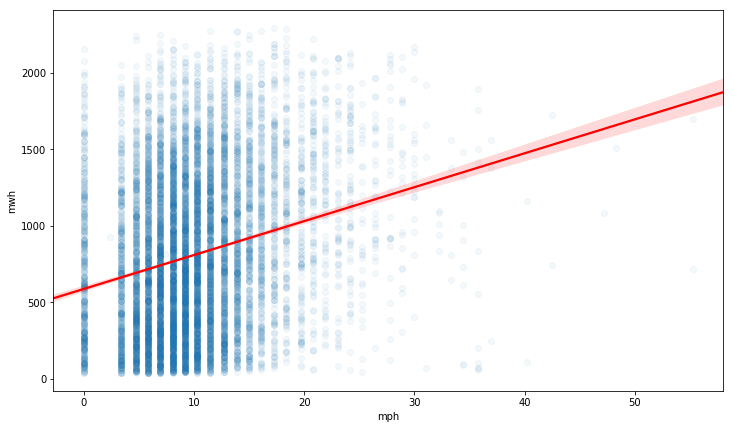

In [14]:
# MWH for PSCO
dfPSCO = slice_ba(windactuals, 'PSCO')
plot_dependency(dfPSCO, 'mph')

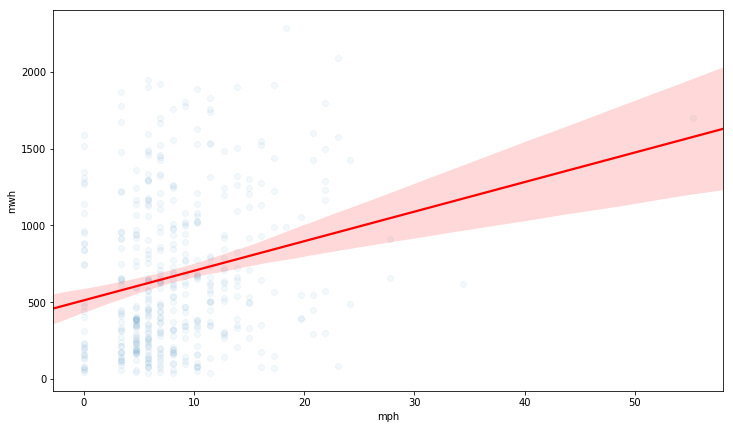

In [15]:
# MWH for 9th hour of PSCO
dfPSCO_HourX = dfPSCO[dfPSCO.Hour==9]
plot_dependency(dfPSCO_HourX, 'mph')

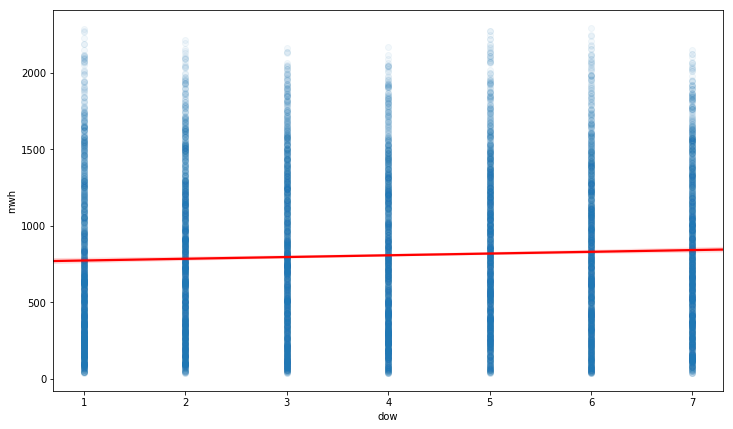

In [16]:
# MWH for weekdays at PSCO
plot_dependency(dfPSCO, 'dow')

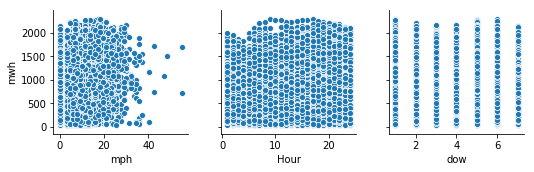

In [17]:
# pairplots for PSCO (MWH for MPH, Hour, DOW)
sns.pairplot(dfPSCO, x_vars=['mph', 'Hour', 'dow'], y_vars=['mwh'])